In [107]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

Data Loading

In [108]:
df = pd.read_csv("cosmicclassifierTraining.csv")
df.head(3)

,Atmospheric Density,Surface Temperature,Gravity,Water Content,Mineral Abundance,Orbital Period,Proximity to Star,Magnetic Field Strength,Radiation Levels,Atmospheric Composition Index,Prediction
0,0.472806,NaN,-0.313872,-2.089299,-0.152201,-0.885649,0.900105,NaN,Category_6,0.692907,5.0
1,4.180154,-1.157515,2.430956,-1.595850,-3.188678,-0.609434,-0.199828,Category_9,Category_9,NaN,0.0
2,-0.129008,1.621592,-0.785741,2.081196,-1.413796,-0.095152,-3.502577,NaN,Category_8,-0.677182,4.0


In [109]:
df.shape

(60000, 11)

                                                  Exploratory Data Analysis & Data Cleaning

Handle Missing Values

In [110]:
df.isna().sum()

Atmospheric Density              2984
Surface Temperature              3032
Gravity                          2984
Water Content                    3077
Mineral Abundance                2921
Orbital Period                   2997
Proximity to Star                2945
Magnetic Field Strength          3058
Radiation Levels                 3021
Atmospheric Composition Index    2942
Prediction                       3039
dtype: int64

In [111]:
df = df.dropna(subset=["Prediction"])

In [112]:
num_cols = ["Atmospheric Density", "Surface Temperature", "Gravity","Water Content", "Mineral Abundance", "Orbital Period","Proximity to Star", "Atmospheric Composition Index"]

cat_cols = ["Magnetic Field Strength", "Radiation Levels"]

In [113]:
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

In [114]:
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [115]:
for col in cat_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts(normalize=True).head(10))  # top 10


Value counts for Magnetic Field Strength:
Magnetic Field Strength
Category_9     0.200909
Category_8     0.148768
Category_10    0.131423
Category_7     0.102298
Category_11    0.101701
Category_12    0.075192
Category_6     0.058075
Category_13    0.052738
Category_14    0.035937
Category_5     0.033567
Name: proportion, dtype: float64

Value counts for Radiation Levels:
Radiation Levels
Category_8     0.212707
Category_9     0.159144
Category_7     0.139201
Category_10    0.136093
Category_11    0.100999
Category_6     0.087112
Category_12    0.059778
Category_5     0.037886
Category_13    0.029037
Category_4     0.014361
Name: proportion, dtype: float64


In [116]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [117]:
df.isnull().sum()

Atmospheric Density                    0
Surface Temperature                    0
Gravity                                0
Water Content                          0
Mineral Abundance                      0
Orbital Period                         0
Proximity to Star                      0
Atmospheric Composition Index          0
Prediction                             0
Magnetic Field Strength_Category_10    0
Magnetic Field Strength_Category_11    0
Magnetic Field Strength_Category_12    0
Magnetic Field Strength_Category_13    0
Magnetic Field Strength_Category_14    0
Magnetic Field Strength_Category_15    0
Magnetic Field Strength_Category_16    0
Magnetic Field Strength_Category_17    0
Magnetic Field Strength_Category_18    0
Magnetic Field Strength_Category_19    0
Magnetic Field Strength_Category_2     0
Magnetic Field Strength_Category_20    0
Magnetic Field Strength_Category_3     0
Magnetic Field Strength_Category_4     0
Magnetic Field Strength_Category_5     0
Magnetic Field S

Handle Duplicates

In [118]:
df.duplicated().sum()

np.int64(0)

In [119]:
df.describe()

,Atmospheric Density,Surface Temperature,Gravity,Water Content,Mineral Abundance,Orbital Period,Proximity to Star,Atmospheric Composition Index,Prediction
count,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000
mean,-0.008676,-0.016921,0.003627,0.002638,0.001535,-0.000529,-0.002835,0.003326,4.454381
std,2.207743,1.887182,1.757744,1.645142,1.566408,1.473648,1.285079,1.091000,2.890055
min,-4.364843,-5.426189,-5.553877,-5.816755,-5.077363,-4.801046,-4.537187,-4.007504,0.000000
25%,-1.478149,-1.361123,-1.190434,-1.147788,-1.012150,-0.983570,-0.890354,-0.655305,2.000000
50%,-0.188784,-0.329290,0.045905,-0.003819,0.040993,0.036056,-0.061354,0.050243,4.000000
75%,1.212618,1.377401,1.181689,0.994203,1.034997,0.994798,0.827552,0.746635,7.000000
max,9.324018,5.638094,6.030290,6.287045,5.584059,5.111014,4.942699,3.852567,9.000000


Data Cleaning:

1. Numeric Columns

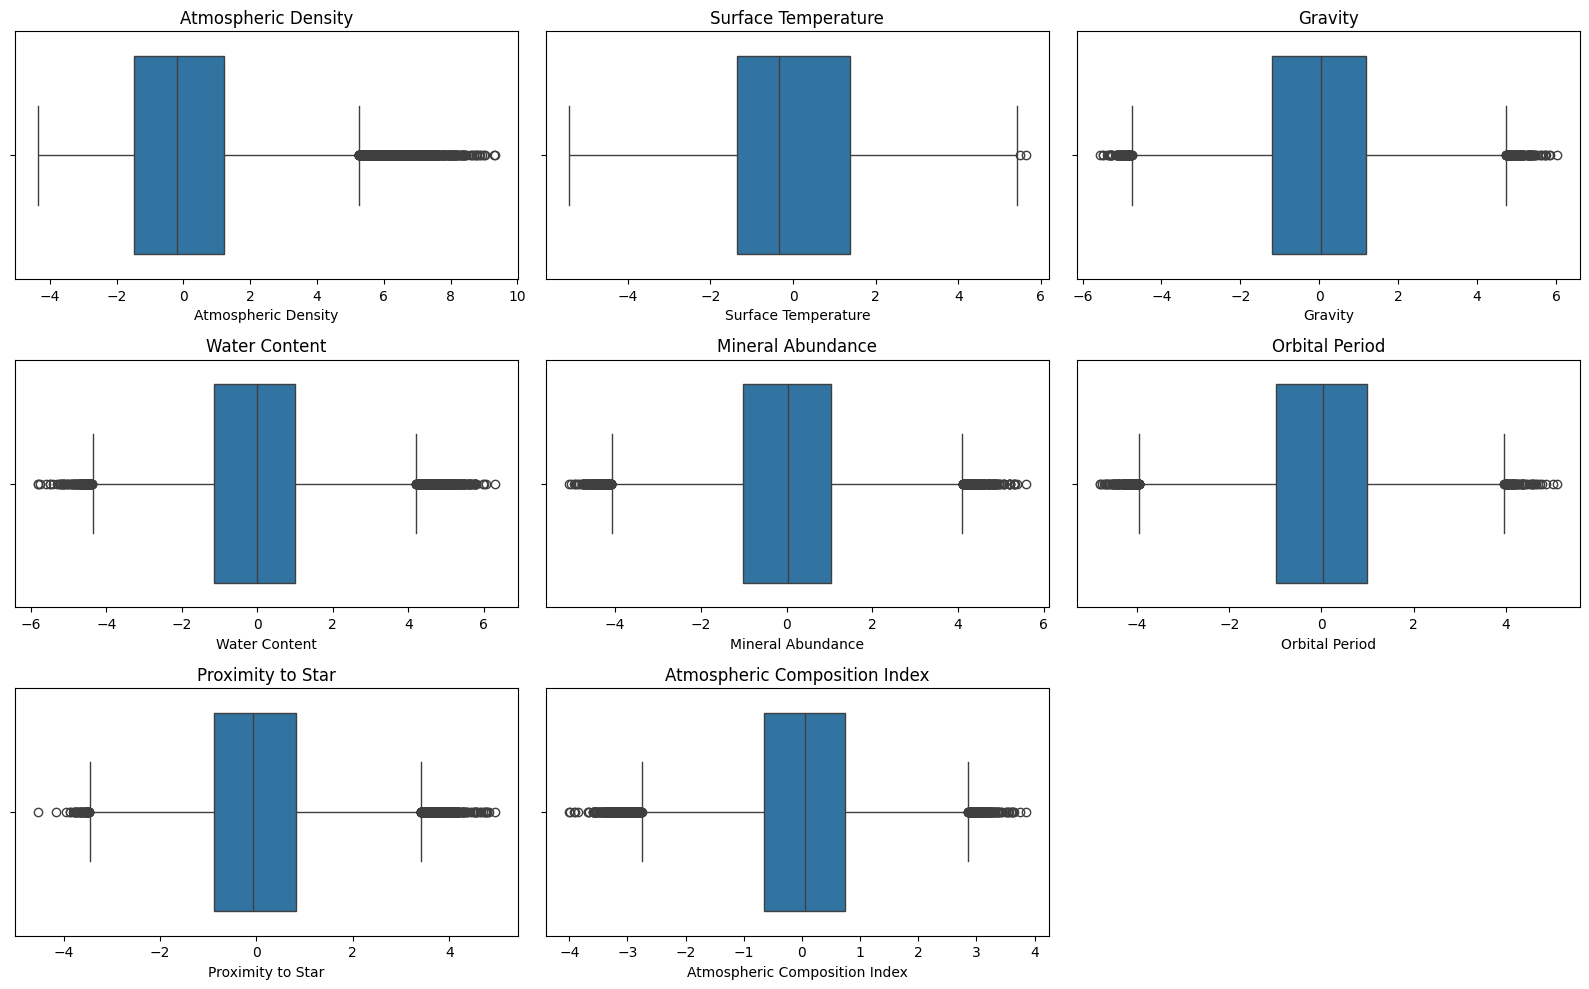

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


### Outlier Treatment: Num Column

In [121]:
# IQR filter
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
lb = Q1 - 1.5 * IQR
ub = Q3 + 1.5 * IQR
mask_iqr = ~((df[num_cols] < lb) | (df[num_cols] > ub)).any(axis=1)

# Z-score filter
z_scores = np.abs(stats.zscore(df[num_cols]))
mask_z = (z_scores < 3).all(axis=1)

# Apply both
df = df[mask_iqr & mask_z]

df.shape

(53276, 47)

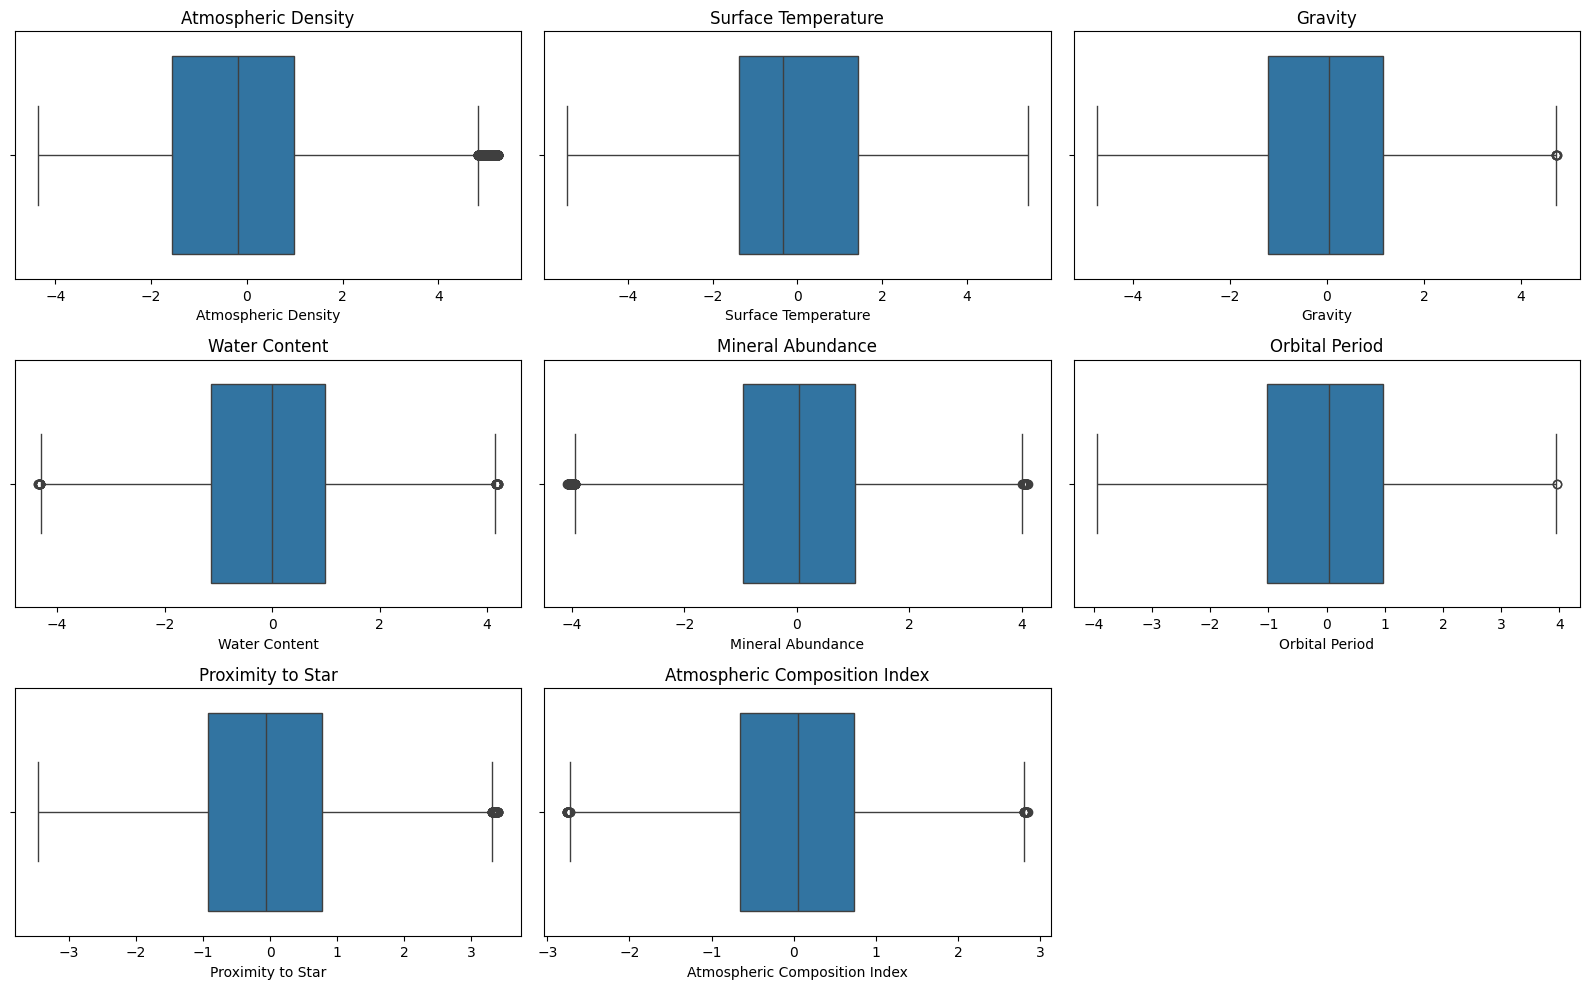

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

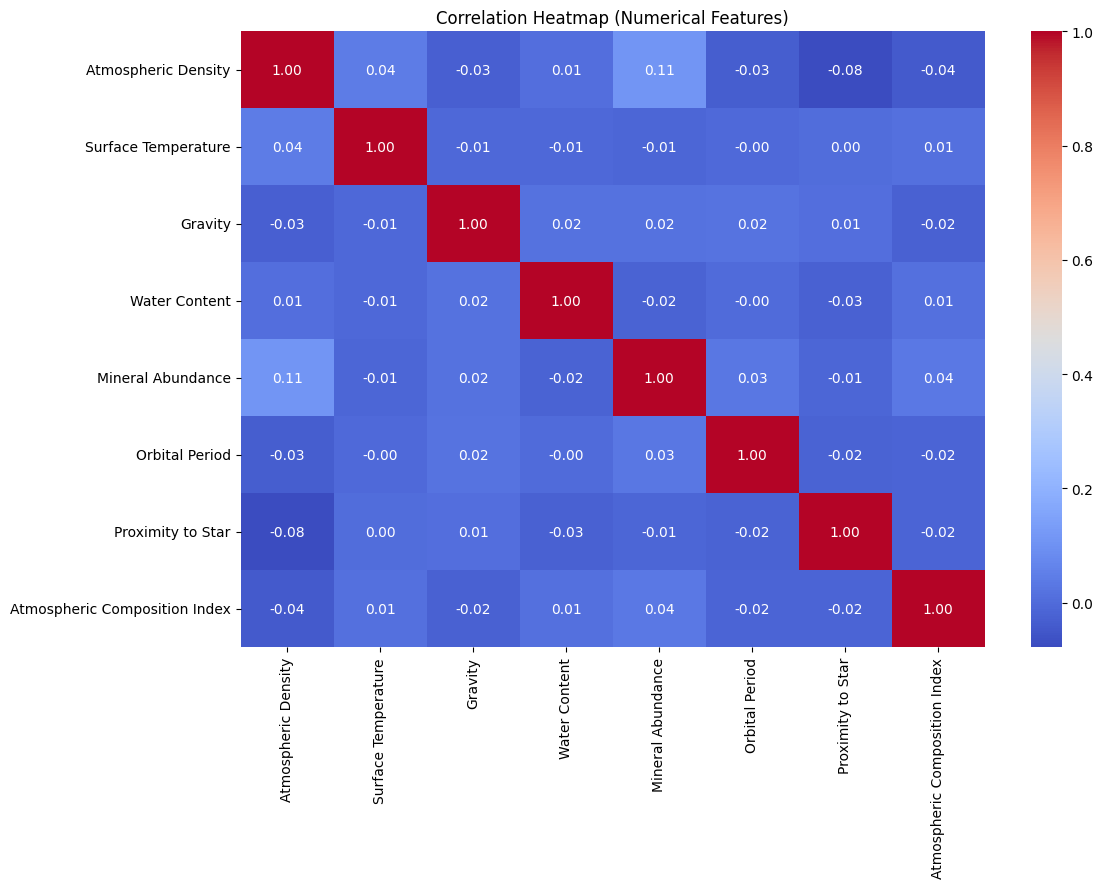

In [123]:
# 2. Check correlation matrix (numerical only)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


In [124]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_temp = df[num_cols].copy()

vif_data = pd.DataFrame()
vif_data["feature"] = X_temp.columns
vif_data["VIF"] = [variance_inflation_factor(X_temp.values, i) for i in range(X_temp.shape[1])]

vif_data


,feature,VIF
0,Atmospheric Density,1.023390
1,Surface Temperature,1.002461
2,Gravity,1.002583
3,Water Content,1.001990
4,Mineral Abundance,1.015310
5,Orbital Period,1.003366
6,Proximity to Star,1.007021
7,Atmospheric Composition Index,1.005640


Class distribution:
 Prediction
1.0    6374
7.0    5712
3.0    5602
9.0    5570
8.0    5403
2.0    5336
4.0    5292
6.0    5006
5.0    4980
0.0    4001
Name: count, dtype: int64


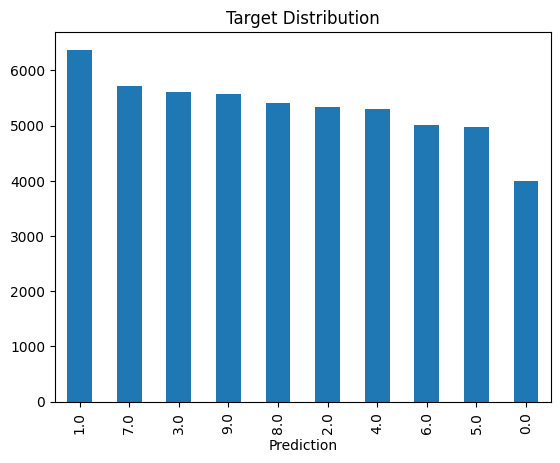

In [125]:
import matplotlib.pyplot as plt

print("Class distribution:\n", df["Prediction"].value_counts())

df["Prediction"].value_counts().plot(kind="bar", title="Target Distribution")
plt.show()

In [126]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [127]:
from sklearn.model_selection import train_test_split

X = df.drop("Prediction", axis=1)
y = df["Prediction"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", random_state=42)
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

## 2. Categorical Columns

In [129]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

results = []

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "F2 Score": fbeta_score(y_test, y_pred, average="weighted", beta=2, zero_division=0)
    })

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,F2 Score
0,Logistic Regression,0.751220,0.750852,0.751220,0.750685,0.750924
1,Random Forest,0.859610,0.859822,0.859610,0.859508,0.859520
2,SVM,0.876877,0.876891,0.876877,0.876822,0.876840
3,XGBoost,0.873968,0.874209,0.873968,0.874052,0.873993


In [131]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5]
}

random_search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric="mlogloss", random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}
Best F1 Score: 0.8757226364024205
